In [3]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
import yaml
from tqdm import tqdm

from erpe.analysis import *
from erpe.experiment_design import *
from erpe.models import *
from erpe.qcal_util import *
from erpe.lqr import *

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

In [4]:
import qcal as qc

from qcal.units import *
from qcal.utils import load_from_pickle
from qcal.backend.qubic.qpu import QubicQPU
from qcal.backend.qubic.utils import qubic_sequence

from qcal.benchmarking.readout import ReadoutFidelity
from qcal.calibration.readout import ReadoutCalibration

from qcal.interface.pygsti.circuits import load_circuits
from qcal.interface.pygsti.transpiler import Transpiler
from qcal.interface.pygsti.datasets import generate_pygsti_dataset

In [5]:
import qcal.settings as settings

logger = logging.getLogger(__name__)

basedir = '/home/jpmarceaux/experiment/'
settings.Settings.config_path = basedir + 'config/'
settings.Settings.data_path = basedir + 'data/'
settings.Settings.save_data = True

#cfg = qc.Config()
akel_config = qc.Config(basedir + 'config/configs/X6Y3/config.yaml')
classifier = load_from_pickle(basedir + 'config/configs/X6Y3/ClassificationManager.pkl')
# cfg = qc.Config(basedir + 'config/Campbell06/X6Y3/config_abhi.yaml')
akel_config.draw_qpu()

In [6]:
from pygsti.io import load_dataset

class BackendInterface:
    """
    The class provides functionality to interface with different backends
    """
    def __init__(self, classifier, backend='qcal'):
        self.classifier = classifier
        self.backend = backend

    def make_dataset(self, pygsti_circ_list, num_shots_per_circuit, config):
        transpiler = Transpiler()
        tcircuits = transpiler.transpile(pygsti_circ_list)

        config.load()
        qpu = QubicQPU(
            config,
            classifier=classifier,
            n_circs_per_seq=num_shots_per_circuit,
            reload_pulse=False,
            zero_between_reload=False
        )
        qpu.run(tcircuits)
        generate_pygsti_dataset(tcircuits, qpu.data_manager.save_path + 'RPE_')
        ds_location = qpu.data_manager.save_path + 'RPE_dataset.txt'
        ds = load_dataset(ds_location)
        return ds

## functions to sort

In [7]:
def estimate_rpe_sigma(num_shots, max_depth):
    return np.pi/(max_depth*np.sqrt(num_shots))

In [9]:
import numpy as np
from scipy.linalg import solve_discrete_are

def dlqr_1param(B, M, N):
  """
  Calculate the infinite horizon, discrete time LQR gain for a 1-parameter problem.

  Args:
    B: The input matrix (scalar).
    Q: The state cost matrix (scalar).
    R: The input cost matrix (scalar).

  Returns:
    The LQR gain (scalar).
  """

  # Solve the discrete-time algebraic Riccati equation (DARE)
  P = solve_discrete_are(1, B, M, N)

  # Calculate the LQR gain
  K = 1/(N + B**2 * P) * B * P

  return K

In [10]:
def dual_kalman_gain(u, prior_covar, obs_covar, Q_add=0):
    P = prior_covar + Q_add
    D = u 
    R = obs_covar
    K = P * D.T /(D * P * D.T + R)
    return K

def dual_kalman_update(b, u, y, prior_covar, obs_covar, Q_add=0):
    K = dual_kalman_gain(u, prior_covar, obs_covar, Q_add)
    b_new = b + K * (y - u * b)
    P_new = (np.eye(prior_covar.shape[0]) - K * u) @ (prior_covar + Q_add)
    return b_new, P_new

In [11]:
def make_initial_Bcovar(last_good_rpe_depth):
    return (np.pi/(last_good_rpe_depth))**2

# Ramsey tune-up

In [15]:
# get initial calibration configuration
qid = 'Q5'
inital_configuration_dict = parse_control_params_from_cfg_1qb(akel_config, qid)
print(inital_configuration_dict)
theta_0 = [inital_configuration_dict['freq'], 
           inital_configuration_dict['amp'], 
           inital_configuration_dict['phase']
           ]

{'freq': 5575357055.67948, 'phase': 0.12446, 'amp': 0.21293}


In [16]:
# get the experiment design
depths_ramsey = [2**i for i in range(13)]
edesign_ramsey = EDesign_Ramsey(depths_ramsey, [qid])
edesign_ramsey.circuit_dict

{Circuit(Gi:Q5@(Q5)): {'+': {'I': {1: Circuit(Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
    2: Circuit(Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gi:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
    4: Circuit(Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
    8: Circuit(Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
    16: Circuit(Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gz

In [17]:
# measure the initial error
num_shots_per_circuit = 512
ds_ramsey0 = make_dataset(akel_config, edesign_ramsey, num_shots_per_circuit, classifier)

INFO:qcal.config: Param ['readout', 'esp', 'enable'] set to False.
INFO:QPU: No batching...
INFO:QPU: Generating sequences...
INFO:QPU: Writing sequences...
INFO:QPU: Measuring...


{'idle': 0.0021512623564206024}
{Circuit(Gi:Q5@(Q5)): {'+': 12}}


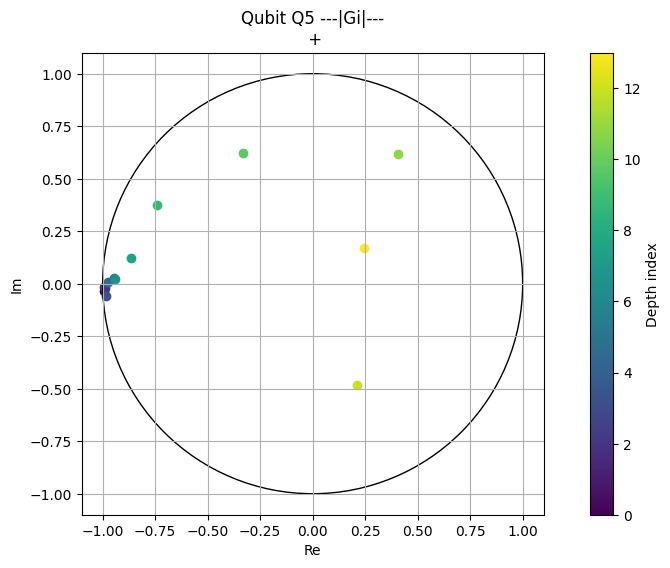

In [ ]:
# analysis 
analysis_ramsey0 = Analysis_Ramsey(ds_ramsey0, edesign_ramsey)
print(analysis_ramsey0.estimates)
print(analysis_ramsey0.last_good_idxs)
analysis_ramsey0.plot_all_signals()

In [26]:
def theta_1qb_to_config_dict(theta):
    return {'freq': theta[0], 'amp': theta[1], 'phase': theta[2]}

In [16]:
# measure a small delta in frequency to estimate the gradient
delta = 1e6 # Hz
theta_delta = [theta_0[0] + delta, theta_0[1], theta_0[2]]
cfg_delta = make_new_config_from_old(akel_config, qid, theta_1qb_to_config_dict(theta_delta))

ds_delta = make_dataset(cfg_delta, edesign_ramsey, num_shots_per_circuit, classifier)
analysis_delta = Analysis_Ramsey(ds_delta, edesign_ramsey)
print(analysis_delta.estimates)
x_ramsey_delta = analysis_delta.estimates

Reading /home/jpmarceaux/experiment/data/2024-11-06/20241106_141753/RPE_dataset.txt: 100%


{'idle': 0.12755833033436303}


In [17]:
x0_ramsey = analysis_ramsey0.estimates['idle']
x0_ramsey_delta = analysis_delta.estimates['idle']

In [18]:
B_ramsey_initial = (x0_ramsey_delta - x0_ramsey)/delta
B_ramsey_covar = 1e-3

print(B_ramsey_initial)

1.2540706797794243e-07


In [2]:
import numpy as np

In [5]:
4*np.pi*10e-9

1.2566370614359172e-07

In [19]:
def make_standard_control_model_covar(last_good_rpe_depth):
    return (np.pi/(last_good_rpe_depth))**2

In [27]:
make_standard_control_model_covar(512)

3.764955292163604e-05

In [15]:
edesign_ramsey.circuit_list

[Circuit(Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
 Circuit(Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gi:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gi:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
 Circuit(Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5@(Q5)),
 Circuit(Gxpi2:Q5Gi:Q5Gi:Q5Gi:Q5Gi:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi

In [ ]:
from abc import ABC, abstractmethod

class CalibrationIterate(ABC):


In [16]:
max_lqr_iterations = 10

# control iterate
initial_config_dict = parse_control_params_from_cfg_1qb(akel_config, qid)
theta_0 = [initial_config_dict['freq'],][0]
ds_0_ramsey = make_dataset(akel_config, edesign_ramsey, num_shots_per_circuit, classifier)
analysis_ramsey0 = Analysis_Ramsey(ds_0_ramsey, edesign_ramsey)
x0_ramsey = analysis_ramsey0.estimates['idle']
stopping_threshold = estimate_rpe_sigma(num_shots_per_circuit, max(depths_ramsey))


print('Initial theta:', theta_0)
print('Initial x0:', x0_ramsey)
print('Stopping threshold:', stopping_threshold)

# LQR definitions
M = 1/estimate_rpe_sigma(num_shots_per_circuit, max(depths_ramsey))**2
N = 1/(1e8)**2

print('Initial B:', B_ramsey_initial)
print('LQR M:', M)
print('LQR N:', N)

assert abs(x0_ramsey) > stopping_threshold

Bs = [1e-7]
#B_covars = [B_ramsey_covar*np.eye(1)]
xs = [x0_ramsey]
thetas = [theta_0]
controls = []
gains = []

# control iterate

for i in range(max_lqr_iterations):
    # get lqr gain 
    G = dlqr_1param(Bs[-1], M, N)

    u = -G*xs[-1]
    controls.append(u)
    gains.append(G)
    theta_new = thetas[-1] + u
    print('Iteration:', i)
    print('u:', u)
    print('theta_new:', theta_new)
    new_config_dict = {'freq': theta_new, 'amp': initial_config_dict['amp'], 'phase': initial_config_dict['phase']}
    new_cfg = make_new_config_from_old(akel_config, qid, new_config_dict, f'ramsey_iterate_{i}.yaml')
    new_ds = make_dataset(new_cfg, edesign_ramsey, num_shots_per_circuit, classifier)
    new_analysis = Analysis_Ramsey(new_ds, edesign_ramsey)
    x_new = new_analysis.estimates['idle']
    print('x_new:', x_new)
    Bs.append(Bs[-1])
    xs.append(x_new)
    thetas.append(theta_new)

    # update the estimate of B with Kalman filter
    #control_residual = xs[-1] - xs[-2]
    #B_obs_covar = make_standard_control_model_covar(depths_ramsey[-1])*np.eye(1)
    #B_new, sigB_new = dual_kalman_update(Bs[-1], u, control_residual, B_covars[-1], B_obs_covar)
    #print('B_new:', B_new)
    #print('sigB_new:', sigB_new)
    #Bs.append(B_new)
    #B_covars.append(sigB_new)

    print('')
    if abs(x_new) < stopping_threshold:
        print('Converged!')
        print('Final frequency:', theta_new)
        print('Percent error in initial', (theta_new - initial_config_dict['freq'])/initial_config_dict['freq'])
        break
    else: 
        print('Remaining distance to threshold:', abs(x_new) - stopping_threshold)
    



Reading /home/jpmarceaux/experiment/data/2024-11-07/20241107_113833/RPE_dataset.txt: 100%


Initial theta: 5575357055.67948
Initial x0: -0.003634555044286447
Stopping threshold: 3.389650679136937e-05


NameError: name 'B_ramsey_initial' is not defined

In [23]:
theta_new[-1] - theta_0

array([-12735.95784378])

In [25]:
stopping_threshold/100e-9

169.48253395684685

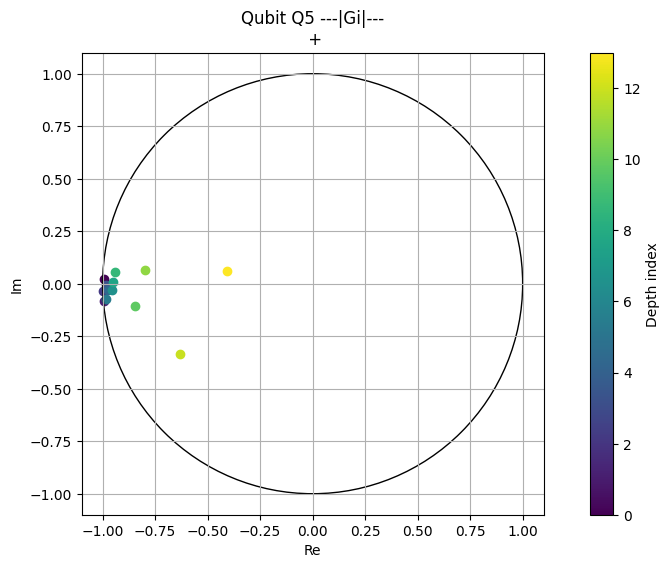

In [26]:
new_analysis.plot_all_signals()

In [27]:
final_theta = thetas[-1]
final_ramsey_config_dict = {'freq': final_theta[0,0], 'amp': inital_configuration_dict['amp'], 'phase': inital_configuration_dict['phase']}
print('Final config:', final_ramsey_config_dict)
final_ramsey_cfg = make_new_config_from_old(akel_config, qid, final_ramsey_config_dict)

Final config: {'freq': 5575355275.951751, 'amp': 0.21479, 'phase': 0.11294}


# X-gate tuneup

In [28]:
depths_xgate = [2**i for i in range(8)]
edesign_xgate = EDesign_Xgate(depths_xgate, [qid])
edesign_overrot = EDesign_Xoverrot(depths_xgate, [qid])

Reading /home/jpmarceaux/experiment/data/2024-11-04/20241104_182140/RPE_dataset.txt: 100%
{'X overrot': -0.0038001310271704725, 'X axis': -0.021907939020729857}
{Circuit(Gxpi2:Q5@(Q5)): {'0': 7}, Circuit(Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5Gzpi2:Q5Gxpi2:Q5Gxpi2:Q5Gzpi2:Q5@(Q5)): {'0': 7}}


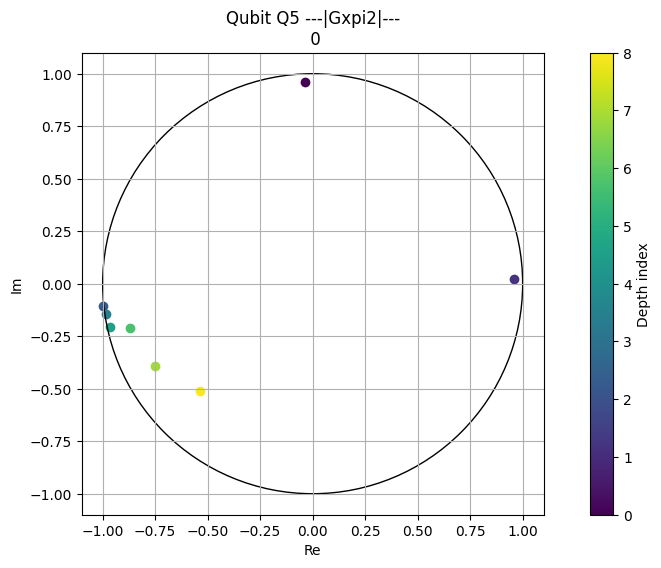

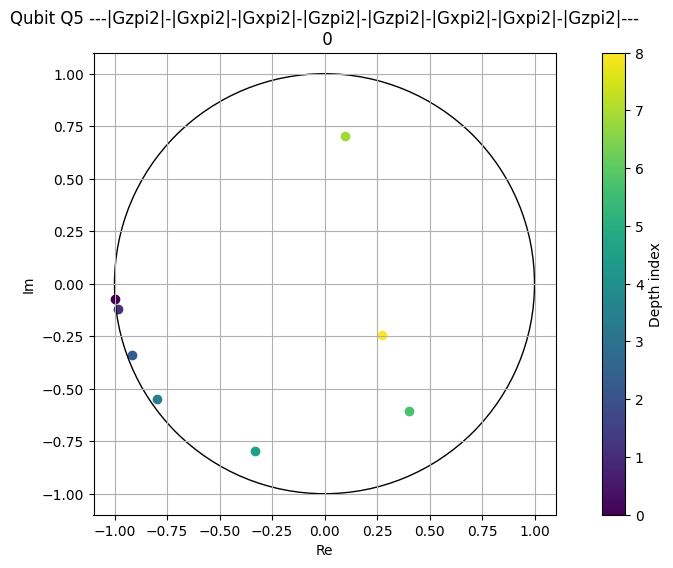

In [29]:
ds_xgate_0 = make_dataset(final_ramsey_cfg, edesign_xgate, num_shots_per_circuit, classifier)
analysis_xgate_0 = Analysis_Xgate(ds_xgate_0, edesign_xgate)
print(analysis_xgate_0.estimates)
print(analysis_xgate_0.last_good_idxs)
analysis_xgate_0.plot_all_signals()

In [31]:
# initial exploration 

# initial drive amp exploration
delta_drive_amp = 0.01
theta_drive_amp = [final_ramsey_config_dict['freq'], final_ramsey_config_dict['amp'] + delta_drive_amp, final_ramsey_config_dict['phase']]
cfg_drive_amp = make_new_config_from_old(akel_config, qid, theta_to_config_dict(theta_drive_amp), 'drive_amp_explore.yaml')
ds_drive_amp = make_dataset(cfg_drive_amp, edesign_overrot, num_shots_per_circuit, classifier)
analysis_drive_amp = Analysis_Xoverrot(ds_drive_amp, edesign_overrot)
delta_overrot_estimate = analysis_drive_amp.estimates['X overrot']

# initial drive phase exploration
delta_drive_phase = np.pi/16
theta_drive_phase = [final_ramsey_config_dict['freq'], final_ramsey_config_dict['amp'], final_ramsey_config_dict['phase'] + delta_drive_phase]
cfg_drive_phase = make_new_config_from_old(akel_config, qid, theta_to_config_dict(theta_drive_phase), 'drive_phase_explore.yaml')
ds_drive_phase = make_dataset(cfg_drive_phase, edesign_xgate, num_shots_per_circuit, classifier)
analysis_drive_phase = Analysis_Xgate(ds_drive_phase, edesign_xgate)
delta_axis_estimate = analysis_drive_phase.estimates['X axis']

b_drive_amp = (delta_overrot_estimate - analysis_xgate_0.estimates['X overrot'])/delta_drive_amp
b_drive_phase = (delta_axis_estimate - analysis_xgate_0.estimates['X axis'])/delta_drive_phase
print('b_drive_amp:', b_drive_amp)
print('b_drive_phase:', b_drive_phase)

Reading /home/jpmarceaux/experiment/data/2024-11-04/20241104_182512/RPE_dataset.txt: 100%
b_drive_amp: 4.445935630510545
b_drive_phase: 1.1975380127089814


In [ ]:
max_lqr_iterations = 5

# control algorithm
initial_config_dict = parse_control_params_from_cfg_1qb(final_ramsey_cfg, qid)
theta_amp_0 = initial_config_dict['amp']
theta_phase_0 = initial_config_dict['phase']
theta_0 = [theta_amp_0, theta_phase_0]

ds_0 = make_dataset(final_ramsey_cfg, edesign_xgate, num_shots_per_circuit, classifier)
analysis_xgate_0 = Analysis_Xgate(ds_0, edesign_xgate)
x0_overrot = analysis_xgate_0.estimates['X overrot']
x0_axis = analysis_xgate_0.estimates['X axis']
x0 = np.array([x0_overrot, x0_axis])
stopping_threshold = estimate_rpe_sigma(num_shots_per_circuit, max(depths_xgate))


print('Initial theta:', theta_0)
print('Initial x0:', x0)
print('Stopping threshold:', stopping_threshold)

# LQR definitions
M_drive = 1
N_drive = 1e-6
M_phase = 1
N_phase = 1e-6

B_drive_initial = b_drive_amp
B_phase_initial = b_drive_phase
B_covar_0 = np.eye(1)

print('Initial drive B estimate:', B_drive_initial)
print('Initial drive B covar:', B_covar_0)
print('LQR M drive:', M_drive)
print('LQR N phase:', N_drive)

print('Initial phase B estimate:', B_phase_initial)
print('Initial phase B covar:', B_covar_0)
print('LQR M phase:', M_phase)
print('LQR N phase:', N_phase)

assert abs(x0_ramsey) > stopping_threshold

B_drives = [B_drive_initial]
Bs_phase = [B_phase_initial]
B_drive_covars = [B_covar_0]
B_phase_covars = [B_covar_0]
xs_overrot = [x0_overrot]
xs_axis = [x0_axis]
thetas_amp = [theta_amp_0]
thetas_phase = [theta_phase_0]
controls_amp = []
controls_phase = []

# control iterate
for i in range(max_lqr_iterations):
    # step 1: amplitude iteration

    # calculate the control
    G_amp = dlqr_1param(B_drives[-1], M_drive, N_drive)
    u_amp = -G_amp*xs_overrot[-1]
    theta_amp_new = thetas_amp[-1] + u_amp
    print('=====================================')
    print('Drive iteration:', i)
    print('gain:', G_amp)
    print('u:', u_amp)
    print('theta_new:', theta_amp_new)

    # make a new config and estimate
    new_config_dict = {'freq': initial_config_dict['freq'], 
                       'amp': theta_amp_new, 
                       'phase': thetas_phase[-1]}
    new_cfg = make_new_config_from_old(akel_config, qid, new_config_dict, f'xgate_amp_iterate_{i}.yaml')
    ds_overrot = make_dataset(new_cfg, edesign_overrot, num_shots_per_circuit, classifier)
    analysis_overrot = Analysis_Xoverrot(ds_overrot, edesign_overrot)
    xhat_overrot = analysis_overrot.estimates['X overrot']
    print('xhat_overrot:', xhat_overrot)
    xs_overrot.append(xhat_overrot)
    thetas_amp.append(theta_amp_new)
    controls_amp.append(u_amp)


    # update the estimate of B with Kalman filter
    control_residual = xhat_overrot - xs_overrot[-2]
    B_new, sigB_new = dual_kalman_update(B_drives[-1], u_amp, control_residual, B_drive_covars[-1], N)
    print('B_new:', B_new)
    print('sigB_new:', sigB_new)
    B_drives.append(B_new)
    B_drive_covars.append(sigB_new)

    # step 2: phase iteration
    # calculate the control
    G_phase = dlqr_1param(Bs_phase[-1], M_phase, N_phase)
    u_phase = -G_phase*xs_axis[-1]
    theta_phase_new = thetas_phase[-1] + u_phase
    print('=====================================')
    print('Phase iteration:', i)
    print('gain:', G_phase)
    print('u:', u_phase)
    print('theta_new:', theta_phase_new)

    # make a new config and estimate
    new_config_dict = {'freq': initial_config_dict['freq'], 
                       'amp': thetas_amp[-1], 
                       'phase': theta_phase_new}
    new_cfg = make_new_config_from_old(akel_config, qid, new_config_dict, f'xgate_phase_iterate_{i}.yaml')
    ds_phase = make_dataset(new_cfg, edesign_xgate, num_shots_per_circuit, classifier)
    analysis_phase = Analysis_Xgate(ds_phase, edesign_xgate)
    xhat_axis = analysis_phase.estimates['X axis']
    print('xhat_axis:', xhat_axis)
    xs_axis.append(xhat_axis)
    thetas_phase.append(theta_phase_new)
    controls_phase.append(u_phase)

    # update the estimate of B with Kalman filter
    control_residual = xhat_axis - xs_axis[-2]
    B_new, sigB_new = dual_kalman_update(Bs_phase[-1], u_phase, control_residual, B_phase_covars[-1], N)
    print('B_new:', B_new)
    print('sigB_new:', sigB_new)
    Bs_phase.append(B_new)
    B_phase_covars.append(sigB_new)

    if abs(xhat_overrot) < stopping_threshold and abs(xhat_axis) < stopping_threshold:
        print('Converged!')
        print('Final amp:', theta_amp_new)
        print('Final phase:', theta_phase_new)
        print('Percent error in initial', (theta_amp_new - initial_config_dict['amp'])/initial_config_dict['amp'])
        print('Percent error in initial', (theta_phase_new - initial_config_dict['phase'])/initial_config_dict['phase'])
        break



final_theta_amp = thetas_amp[-1]
final_theta_phase = thetas_phase[-1]


Reading /home/jpmarceaux/experiment/data/2024-11-04/20241104_182755/RPE_dataset.txt: 100%
xhat_axis: -0.0003235233976956495
B_new: [[1.18045154]]
sigB_new: [[2.78956858e-11]]
Converged!
Final amp: [[0.21569261]]
Final phase: [[0.13187355]]
Percent error in initial [[0.00420227]]
Percent error in initial [[0.16764257]]


In [42]:
final_xgate_config_dict = {'freq': final_ramsey_config_dict['freq'], 'amp': final_theta_amp, 'phase': final_theta_phase}
print('Final config:', final_xgate_config_dict)
final_xgate_cfg = make_new_config_from_old(akel_config, qid, final_xgate_config_dict, 'final_xgate.yaml')

Final config: {'freq': 5575355275.951751, 'amp': array([[0.21569261]]), 'phase': array([[0.13187355]])}


Reading /home/jpmarceaux/experiment/data/2024-11-04/20241104_183108/RPE_dataset.txt: 100%


{'X overrot': -0.0021923931699503463, 'X axis': -0.001862634392348585}


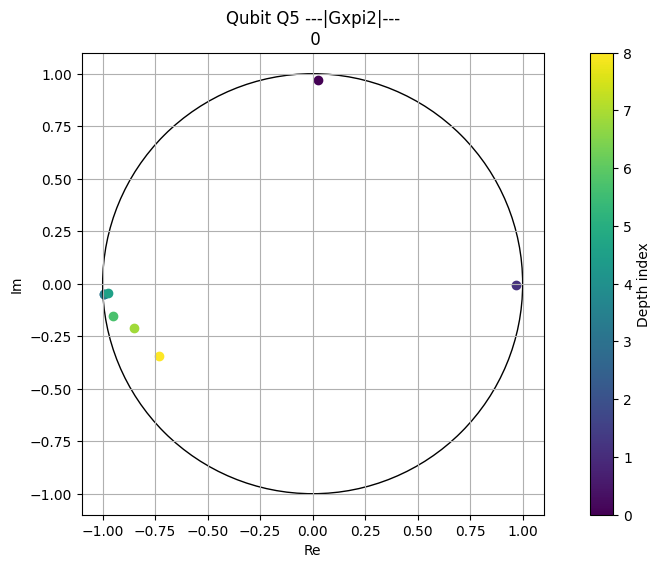

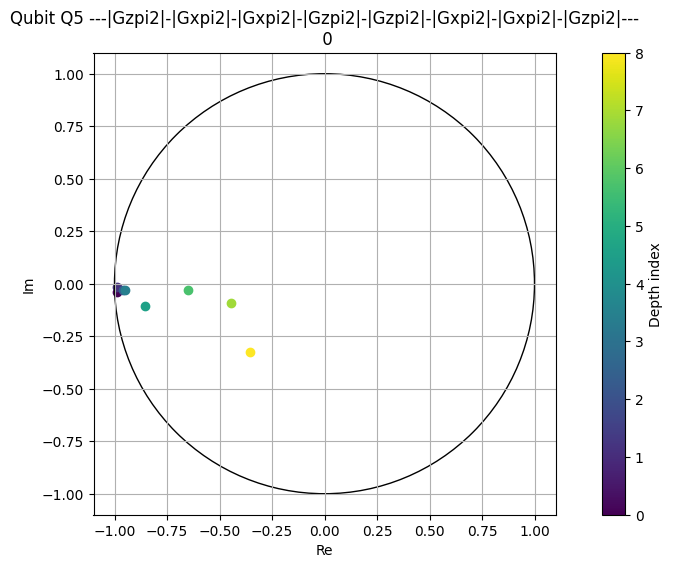

In [43]:
# run a final anlaysis with the final config
ds_final = make_dataset(final_xgate_cfg, edesign_xgate, num_shots_per_circuit, classifier)
analysis_final = Analysis_Xgate(ds_final, edesign_xgate)
print(analysis_final.estimates)
analysis_final.plot_all_signals()


# Full tuneup on a second qubit

# Controlled-Z iterate

In [45]:
qids = ['Q4', 'Q5']
depths = [2**i for i in range(6)]
n_shots = 512
edesign_cz_0 = EDesign_CZ(depths, qids)
ds_cz_0 = make_dataset(final_xgate_cfg, edesign_cz_0, n_shots, classifier)

Reading /home/jpmarceaux/experiment/data/2024-11-04/20241104_183333/RPE_dataset.txt: 100%


{'IZ': -0.04308628026383765, 'ZI': -0.07099859095217909, 'ZZ': 0.09179277200199287}
{Circuit(Gcz:Q4:Q5@(Q4,Q5)): {'0+': 5, '1+': 5, '+1': 5}}


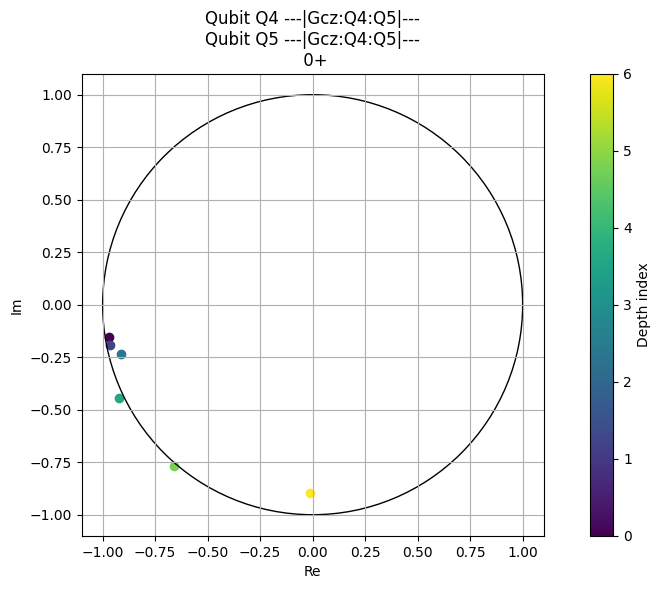

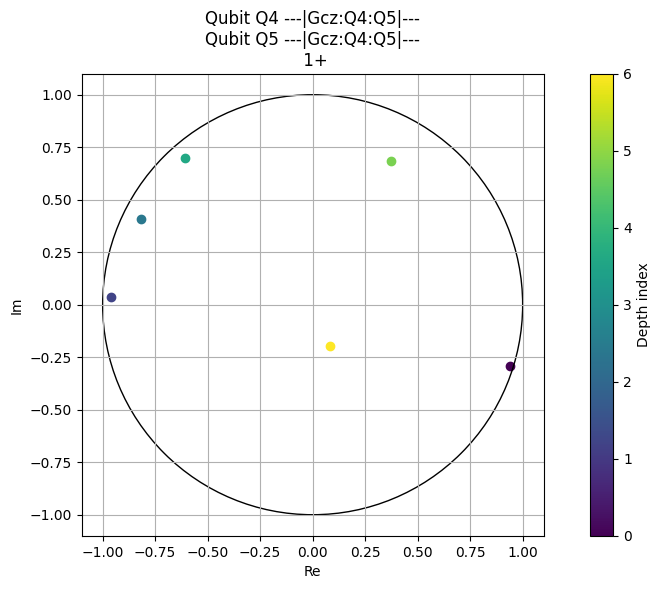

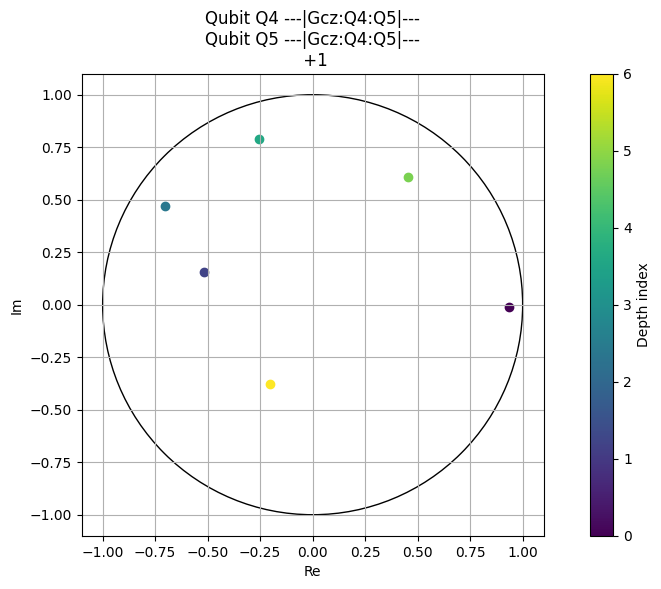

In [46]:
analysis_cz0 = Analysis_CZ(ds_cz_0, edesign_cz_0)
print(analysis_cz0.estimates)
print(analysis_cz0.last_good_idxs)
analysis_cz0.plot_all_signals()

In [71]:
def parse_cz_control_params_from_cfg(cfg, qids):
    with open(cfg.filename, 'r') as f:
        config_yaml = yaml.safe_load(f)
    qidx = [int(qid[1:]) for qid in qids]
    assert len(qids) == 2
    key_pair = f'({qidx[0]}, {qidx[1]})'
    drive_amp_q1 = config_yaml['two_qubit'][key_pair]['CZ']['pulse'][0]['kwargs']['amp']
    drive_amp_q1 = config_yaml['two_qubit'][key_pair]['CZ']['pulse'][1]['kwargs']['amp']
    assert drive_amp_q1 == drive_amp_q1
    vz_phase_q1 = config_yaml['two_qubit'][key_pair]['CZ']['pulse'][2]['kwargs']['phase']
    vz_phase_q2 = config_yaml['two_qubit'][key_pair]['CZ']['pulse'][3]['kwargs']['phase']
    return {
        'cz amp': drive_amp_q1,
        'cz vphase 1': vz_phase_q1,
        'cz vphase 2': vz_phase_q2
    }
    
def make_new_cz_config_from_old(cfg, qids, config_dict, new_filename='temp.yaml'):
    """
    makes a new config with CZ updates -- does not change the old
    """
    with open(cfg.filename, 'r') as f:
        config_yaml = yaml.safe_load(f)
    qidx = [int(qid[1:]) for qid in qids]
    key_pair = f'({qidx[0]}, {qidx[1]})'
    config_yaml['two_qubit'][key_pair]['CZ']['pulse'][0]['kwargs']['amp'] = float(config_dict['cz amp'])
    config_yaml['two_qubit'][key_pair]['CZ']['pulse'][1]['kwargs']['amp'] = float(config_dict['cz amp'])
    config_yaml['two_qubit'][key_pair]['CZ']['pulse'][2]['kwargs']['phase'] = float(config_dict['cz vphase 1'])
    config_yaml['two_qubit'][key_pair]['CZ']['pulse'][3]['kwargs']['phase'] = float(config_dict['cz vphase 2'])
    with open('configurations/'+new_filename, 'w') as f:
        yaml.dump(config_yaml, f)
    return qc.Config('configurations/'+new_filename)

def theta_cz_to_config_dict(theta_cz):
    return {'cz amp': theta_cz[0], 'cz vphase 1': theta_cz[1], 'cz vphase 2': theta_cz[2]}

In [73]:
initial_cz_config

{'cz amp': 0.31425, 'cz vphase 1': 1.43531, 'cz vphase 2': -0.49058}

In [ ]:
initial_cz_control_dict = parse_cz_control_params_from_cfg(final_xgate_cfg, qids)
print(initial_cz_control_dict)

{'cz amp': 0.31425, 'cz vphase 1': 1.43531, 'cz vphase 2': -0.49058}


In [76]:
# exploration on a line

cz_line_perturbations = [-0.01, -0.005, 0, 0.005, 0.01]
cz_line_results = []
for perturbation in cz_line_perturbations:
    theta_perturb = [initial_cz_control_dict['cz amp'] + perturbation, initial_cz_control_dict['cz vphase 1'], initial_cz_control_dict['cz vphase 2']]
    cfg_perturb = make_new_cz_config_from_old(final_xgate_cfg, qids, theta_cz_to_config_dict(theta_perturb), f'cz_line_perturb_{perturbation}.yaml')
    ds_perturb = make_dataset(cfg_perturb, edesign_cz_0, n_shots, classifier)
    analysis_perturb = Analysis_CZ(ds_perturb, edesign_cz_0)
    cz_line_results.append(analysis_perturb)

Reading /home/jpmarceaux/experiment/data/2024-11-04/20241104_190059/RPE_dataset.txt: 100%


Text(0.5, 1.0, 'ZZ')

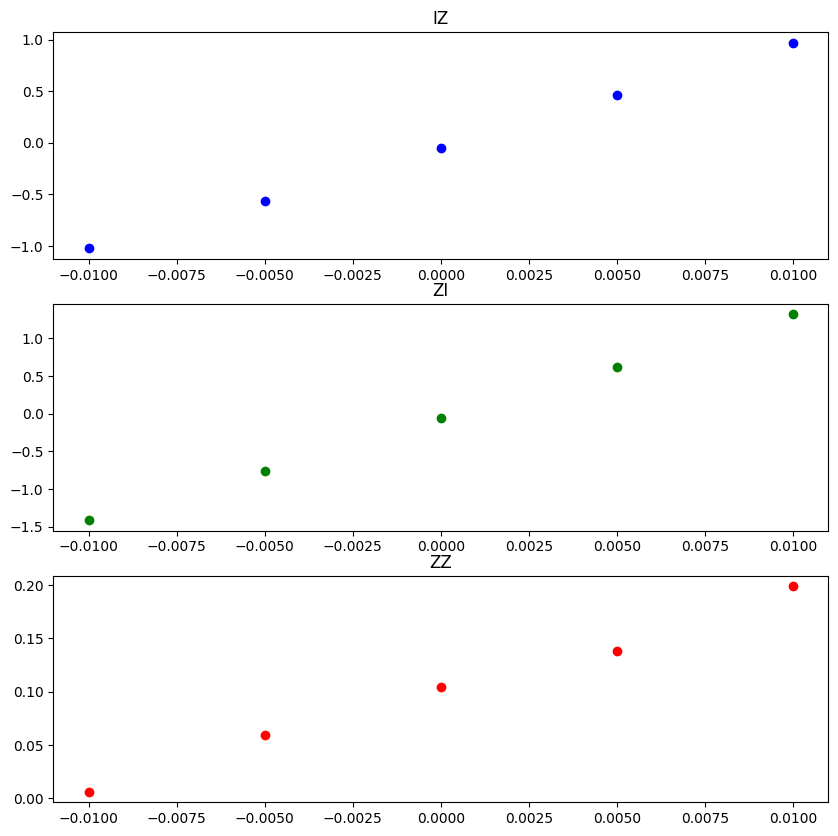

In [77]:
# plot the results on IZ, ZI, and ZZ
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for idx, analysis in enumerate(cz_line_results):
    IZ_est = analysis.estimates['IZ']
    ZI_est = analysis.estimates['ZI']
    ZZ_est = analysis.estimates['ZZ']
    axs[0].scatter(cz_line_perturbations[idx], IZ_est, color='blue')
    axs[1].scatter(cz_line_perturbations[idx], ZI_est, color='green')
    axs[2].scatter(cz_line_perturbations[idx], ZZ_est, color='red')
axs[0].set_title('IZ')
axs[1].set_title('ZI')
axs[2].set_title('ZZ')


In [78]:
# # initial exploration 

delta_cz_drive_amp = 0.01
theta_cz_delta = [initial_cz_control_dict['cz amp'] + delta_cz_drive_amp, initial_cz_control_dict['cz vphase 1'], initial_cz_control_dict['cz vphase 2']]
cz_delta_dict = {'cz amp': theta_cz_delta[0], 'cz vphase 1': theta_cz_delta[1], 'cz vphase 2': theta_cz_delta[2]}
cfg_cz_delta = make_new_cz_config_from_old(final_xgate_cfg, qids, cz_delta_dict, 'cz_drive_amp_explore.yaml')
ds_cz_delta = make_dataset(cfg_cz_delta, edesign_cz_0, n_shots, classifier)
analysis_cz_delta = Analysis_CZ(ds_cz_delta, edesign_cz_0)
delta_ZZ_estimate = analysis_cz_delta.estimates['ZZ']

b_cz_drive_amp = (delta_ZZ_estimate - analysis_cz0.estimates['ZZ'])/delta_cz_drive_amp
print('b_cz_drive_amp:', b_cz_drive_amp)


Reading /home/jpmarceaux/experiment/data/2024-11-04/20241104_190452/RPE_dataset.txt: 100%
b_cz_drive_amp: 9.995006417334595


In [79]:
edesign_cz_0.depths

[1, 2, 4, 8, 16, 32]

In [83]:
max_lqr_iterations = 10

# control iterate
initial_config_dict = parse_cz_control_params_from_cfg(final_xgate_cfg, qids)
theta_cz_0 = [initial_config_dict['cz amp'], initial_config_dict['cz vphase 1'], initial_config_dict['cz vphase 2']]
ds_0_cz = make_dataset(final_xgate_cfg, edesign_cz_0, num_shots_per_circuit, classifier)
analysis_cz0 = Analysis_CZ(ds_0_cz, edesign_cz_0)
x0_zz = analysis_cz0.estimates['ZZ']
stopping_threshold = estimate_rpe_sigma(num_shots_per_circuit, max(edesign_cz_0.depths))


print('Initial theta:', theta_0)
print('Initial x0:', x0_ramsey)
print('Stopping threshold:', stopping_threshold)

# LQR definitions
M = 1
N = 1e-7

# dual definitions
B_covar_initial = 1*np.eye(1)

print('Initial B:', b_cz_drive_amp)
print('Iniital B covar:', B_covar_initial)
print('LQR M:', M)
print('LQR N:', N)

assert abs(x0_ramsey) > stopping_threshold

Bs = [b_cz_drive_amp]
B_covars = [B_covar_initial]
xs = [x0_zz]
thetas = [theta_cz_0]
controls = []
gains = []

# control iterate

for i in range(max_lqr_iterations):
    # get lqr gain 
    G = dlqr_1param(Bs[-1], M, N)

    u = -G*xs[-1]
    controls.append(u)
    gains.append(G)
    theta_new = thetas[-1] + u
    print('Iteration:', i)
    print('u:', u)
    print('theta_new:', theta_new)
    new_config_dict = {'cz amp': theta_new[0, 0], 'cz vphase 1': initial_config_dict['cz vphase 1'], 'cz vphase 2': initial_config_dict['cz vphase 2']}
    new_cfg = make_new_cz_config_from_old(final_xgate_cfg, qids, new_config_dict, f'cz_iterate_{i}.yaml')
    new_ds = make_dataset(new_cfg, edesign_cz_0, num_shots_per_circuit, classifier)
    new_analysis = Analysis_CZ(new_ds, edesign_cz_0)
    x_new = new_analysis.estimates['ZZ']
    print('x_new:', x_new)
    Bs.append(Bs[-1])
    xs.append(x_new)
    thetas.append(theta_new)

    # update the estimate of B with Kalman filter
    control_residual = xs[-1] - xs[-2]
    B_obs_covar = make_standard_control_model_covar(edesign_cz_0.depths[-1])*np.eye(1)
    B_new, sigB_new = dual_kalman_update(Bs[-1], u, control_residual, B_covars[-1], B_obs_covar)
    print('B_new:', B_new)
    print('sigB_new:', sigB_new)
    Bs.append(B_new)
    B_covars.append(sigB_new)

    print('')
    if abs(x_new) < stopping_threshold:
        print('Converged!')
        print('Final drive amp:', theta_new)
        print('Percent error in initial', (theta_new - initial_config_dict['freq'])/initial_config_dict['freq'])
        break
    else: 
        print('Remaining distance to threshold:', abs(x_new) - stopping_threshold)
    



Reading /home/jpmarceaux/experiment/data/2024-11-04/20241104_192025/RPE_dataset.txt: 100%
x_new: 0.00129736383210588
B_new: [[9.97691589]]
sigB_new: [[0.98872401]]

Converged!
Final drive amp: [[ 0.3011502  1.4222102 -0.5036798]]


KeyError: 'freq'